# Data description & Problem statement: 
The dataset is related to red vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests. For more details, please check: https://archive.ics.uci.edu/ml/datasets/wine+quality
* Dataset is imbalanced. The data has 4898 rows and 12 columns.
* This is a classification problem. The classification goal is to predict wine quality based on physicochemical tests.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build the ensemble method, i.e. Bagging model, Soft Voting model, and Stacked model individually
   # Model Evaluation: 
- Evaluate the Ensemble models with Cross-Validation technique, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/wine quality/winequality-red.csv', sep=';') 

df['quality']=df['quality'].map({3:'L', 4:'L', 5:'L', 6:'L', 7:'H', 8:'H'})
df['quality']=df['quality'].map({'L':0,  'H':1})

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,0
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,0
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,0
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,0
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,0


In [4]:
X=df.drop('quality', axis=1)
y=df['quality']

In [5]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# Removing outliers:
remove_outliers(X_train, y_train, ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
      'pH', 'sulphates', 'alcohol'], thresh=9)

number of outliers removed :   2


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=MinMaxScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# 1)  Bagging meta-estimator with XGBoost:

In [8]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import BaggingClassifier

model=XGBClassifier(gamma= 0.1, max_depth= 5, min_child_weight= 2)

bag=BaggingClassifier(model, n_estimators = 50, max_samples=0.8, max_features=0.9, random_state=42)
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(bag, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("AUC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.91856061 0.87983092 0.92315821 0.91198671 0.88753019] 

AUC Accuracy: 0.90 (+/- 0.02)


In [9]:
# Grid-Search for the best Bagging parameters: 

# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_train)

from sklearn.model_selection import GridSearchCV
param={'max_samples':[0.5, 0.7, 0.9, 1], 'max_features':[0.5, 0.7, 0.9, 1]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(BaggingClassifier(model, n_estimators = 50, random_state=42), param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_train, y_train, sample_weight=sw)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_samples,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,5.071772,0.001244,0.153589,0.007329,0.7,0.9,"{'max_features': 0.7, 'max_samples': 0.9}",0.888300,0.914385,0.887285,0.896658,0.012542,1,0.998388,0.999040,0.999089,0.998839,0.000319
10,6.634926,0.090659,0.189162,0.017958,0.9,0.9,"{'max_features': 0.9, 'max_samples': 0.9}",0.885410,0.914976,0.885316,0.895234,0.013960,2,0.997386,0.998499,0.998754,0.998213,0.000594
5,5.228685,0.351489,0.166887,0.004485,0.7,0.7,"{'max_features': 0.7, 'max_samples': 0.7}",0.881396,0.913473,0.882253,0.892373,0.014924,3,0.995368,0.997349,0.996221,0.996313,0.000811


In [10]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_features': 0.7, 'max_samples': 0.9}
Best validation accuracy:  0.90 (+/- 0.01)
Test score:  0.92


In [11]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.95      0.94      0.95       344
          1       0.67      0.70      0.68        56

avg / total       0.91      0.91      0.91       400



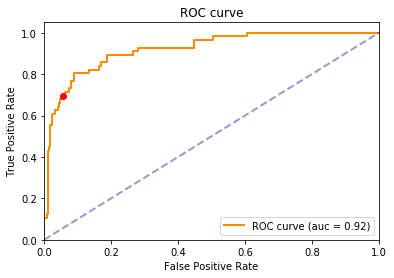

In [12]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

# 2) Voting classifier with XGboost, Logistic Regression & Random Forest:

In [13]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression


clf1=XGBClassifier(gamma= 0.1, max_depth= 5, min_child_weight= 2, class_weight='balanced')
clf2=RandomForestClassifier(max_depth= 22, max_features= 2, min_samples_leaf= 1, 
                            n_estimators= 70, random_state=42, class_weight='balanced')
clf3=LogisticRegression(C= 5, penalty= 'l1', random_state=42, class_weight='balanced')
#clf2=AdaBoostClassifier(random_state=42)


vote=VotingClassifier([('XGB', clf1), ('LR', clf2), ('RF', clf3)],  voting='soft', weights=[3, 1, 1])

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(vote, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("AUC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.92 0.87 0.94 0.91 0.89] 

AUC Accuracy: 0.91 (+/- 0.02)


In [14]:
# Grid-Search for the best Voting Parameters: 

from sklearn.model_selection import GridSearchCV
param={'weights': [[1, 1, 1], [1, 2, 3], [1, 3, 2], [2, 3, 1], [2, 1, 3], [3, 2, 1], [3, 1, 2], 
                   [1, 0, 0], [0, 1, 0], [0, 0 , 1], [1, 1, 0], [1, 0, 1], [0, 1, 1],
                   [2, 1, 0], [2, 0, 1], [0, 2, 1], [1, 2, 0], [1, 0, 2], [0, 1, 2]] }

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(VotingClassifier([('XGB', clf1), ('LR', clf2), ('RF', clf3)], voting='soft'), 
                                          param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
16,0.394944,0.014815,0.018950,0.006360,"[1, 2, 0]","{'weights': [1, 2, 0]}",0.886855,0.925013,0.898824,0.903554,0.015941,1,1.000000,1.000000,1.0,1.000000,0.000000
8,0.373002,0.023991,0.017287,0.003391,"[0, 1, 0]","{'weights': [0, 1, 0]}",0.883590,0.931911,0.894039,0.903171,0.020765,2,1.000000,1.000000,1.0,1.000000,0.000000
10,0.397936,0.014725,0.020945,0.006361,"[1, 1, 0]","{'weights': [1, 1, 0]}",0.886694,0.919163,0.896473,0.900768,0.013605,3,0.999986,0.999986,1.0,0.999991,0.000006


In [15]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'weights': [1, 2, 0]}
Best validation accuracy:  0.90 (+/- 0.02)
Test score:  0.93


In [16]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.93      0.98      0.96       344
          1       0.84      0.55      0.67        56

avg / total       0.92      0.92      0.92       400



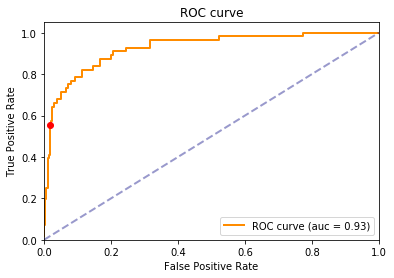

In [17]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

# 3) Stacked classifier with XGBoost, Logistic Regression & Random Forest:



In [18]:
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

clf1=XGBClassifier(gamma= 0.1, max_depth= 5, min_child_weight= 2, class_weight='balanced')
clf2=LogisticRegression(C= 5, penalty= 'l1', random_state=42, class_weight='balanced')

clf3=RandomForestClassifier(max_depth= 22, max_features= 2, min_samples_leaf= 1, 
                           n_estimators= 70, random_state=42, class_weight='balanced')

meta_clf=LogisticRegression(C=0.5, class_weight='balanced')

stack=StackingClassifier([clf1, clf2, clf3], meta_classifier= meta_clf, use_probas=True)

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(stack, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("AUC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.93 0.89 0.93 0.92 0.89] 

AUC Accuracy: 0.91 (+/- 0.02)


In [19]:
# Grid-Search for the best model parameters: 

from sklearn.model_selection import GridSearchCV

param={'meta-logisticregression__penalty':['l1', 'l2'], 'meta-logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]}

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search=GridSearchCV(StackingClassifier([clf1, clf2, clf3], meta_classifier= meta_clf, use_probas=True), 
                                                                                          param, cv=kfold, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_meta-logisticregression__C,param_meta-logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
14,0.245542,0.010544,0.009176,0.000747,10,l1,"{'meta-logisticregression__C': 10, 'meta-logis...",0.936626,0.891606,0.936594,...,0.914958,0.019128,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
12,0.262698,0.023556,0.009176,0.001716,5,l1,"{'meta-logisticregression__C': 5, 'meta-logist...",0.936772,0.889493,0.935990,...,0.914415,0.019556,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.323336,0.018253,0.011970,0.000894,0.1,l1,"{'meta-logisticregression__C': 0.1, 'meta-logi...",0.936772,0.889493,0.936443,...,0.914053,0.019729,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [20]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'meta-logisticregression__C': 10, 'meta-logisticregression__penalty': 'l1'}
Best validation accuracy:  0.91 (+/- 0.02)
Test score:  0.92


In [21]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.94      0.97      0.95       344
          1       0.77      0.59      0.67        56

avg / total       0.91      0.92      0.91       400



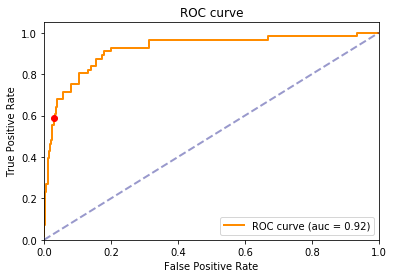

In [22]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()